<p><font size="6"><b> Geospatial Vector Data in Python</b></font></p>

**Main Objectives**
- Importing vector data using geopandas
- Visualising vector data
- Introduction to GeoDataFrame
- Different types of geometries
- Spatial relationships
- Spatial operations

## Setup

In [ ]:
%%time
import os
from pathlib import Path

data_dir = Path("data")

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Mount drive to access data
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install uv
    !uv pip install --system \
        "fsspec>=2024.10.0" \
        "geopandas>=1.0.1" \
        "matplotlib>=3.9.2" \
        "pyarrow>=18.0.0" \
        "numpy>=2.1.3" \
        "folium" \
        "mapclassify"

    data_dir = Path("/content/drive/MyDrive/ingarss_workshop_2024")

    print("✅ Environment activated and data ready!")

## Importing geospatial data

Geospatial data is often available from specific GIS file formats or data stores, like ESRI shapefiles, GeoJSON files, geopackage files, PostGIS (PostgreSQL) database, ...

In [ ]:
import geopandas as gpd

In [ ]:
state = gpd.read_file(f"{data_dir}/karnataka_district/KA_subdistrict.shp")

In [ ]:
state.head()

In [ ]:
state.plot()

In [ ]:
# !pip install folium matplotlib mapclassify
state.explore()

What do we observe:

- Using `.head()` we can see the first rows of the dataset, just like we can do with Pandas.
- There is a `geometry` column and the different countries are represented as polygons
- We can use the `.plot()` (matplotlib) or `explore()` (Folium / Leaflet.js) method to quickly get a *basic* visualization of the data

## What's a GeoDataFrame?

We used the GeoPandas library to read in the geospatial data, and this returned us a `GeoDataFrame`:

In [ ]:
type(state)

A GeoDataFrame contains a tabular, geospatial dataset:

* It has a **'geometry' column** that holds the geometry information (or features in GeoJSON).
* The other columns are the **attributes** (or properties in GeoJSON) that describe each of the geometries

Such a `GeoDataFrame` is just like a pandas `DataFrame`, but with some additional functionality for working with geospatial data:

* A `.geometry` attribute that always returns the column with the geometry information (returning a GeoSeries). The column name itself does not necessarily need to be 'geometry', but it will always be accessible as the `.geometry` attribute.
* It has some extra methods for working with spatial data (area, distance, buffer, intersection, ...), which we will learn in later notebooks

In [ ]:
state.geometry

In [ ]:
type(state.geometry)

In [ ]:
state.geometry.area

**It's still a DataFrame**, so we have all the Pandas functionality available to use on the geospatial dataset, and to do data manipulations with the attributes and geometry information together.

Or, we can use boolean filtering to select a subset of the dataframe based on a condition:

In [ ]:
district = state[state['district'] == 'Dharwad']

In [ ]:
district.plot();

---

The rest of the tutorial is going to assume you already know some pandas basics, but we will try to give hints for that part for those that are not familiar.   
A few resources in case you want to learn more about pandas:

- Pandas docs: https://pandas.pydata.org/pandas-docs/stable/10min.html
- Other tutorials: chapter from pandas in https://jakevdp.github.io/PythonDataScienceHandbook/, https://github.com/jorisvandenbossche/pandas-tutorial, https://github.com/TomAugspurger/pandas-head-to-tail, ...

<div class="alert alert-info" style="font-size:120%">

⚛ **REMEMBER:** <br>
* A `GeoDataFrame` allows to perform typical tabular data analysis together with spatial operations
* A `GeoDataFrame` (or *Feature Collection*) consists of:
    * **Geometries** or **features**: the spatial objects
    * **Attributes** or **properties**: columns with information about each spatial object

</div>

## Geometries: Points, Linestrings and Polygons

Spatial **vector** data can consist of different types, and the 3 fundamental types are:

![](https://github.com/developmentseed/ingarss-workshop-2024/blob/main/book/docs/img/simple_features_3_text.svg?raw=1)

* **Point** data: represents a single point in space.
* **Line** data ("LineString"): represents a sequence of points that form a line.
* **Polygon** data: represents a filled area.

And each of them can also be combined in multi-part geometries (See https://shapely.readthedocs.io/en/stable/manual.html#geometric-objects for extensive overview).

For the example we have seen up to now, the individual geometry objects are Polygons:

In [ ]:
print(state.geometry[2])

### The `shapely` library

The individual geometry objects are provided by the [`shapely`](https://shapely.readthedocs.io/en/stable/) library

To construct one ourselves:

In [ ]:
from shapely.geometry import Point, Polygon, LineString

In [ ]:
p = Point(0, 0)

In [ ]:
print(p)

In [ ]:
polygon = Polygon([(1, 1), (2,2), (2, 1)])

In [ ]:
polygon.area

In [ ]:
polygon.distance(p)

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

Single geometries are represented by `shapely` objects:

* If you access a single geometry of a GeoDataFrame, you get a shapely geometry object
* Those objects have similar functionality as geopandas objects (GeoDataFrame/GeoSeries). For example:
    * `single_shapely_object.distance(other_point)` -> distance between two points
    * `geodataframe.distance(other_point)` ->  distance for each point in the geodataframe to the other point

</div>

## Spatial relationships

An important aspect of geospatial data is that we can look at *spatial relationships*: how two spatial objects relate to each other (whether they overlap, intersect, contain, .. one another).

The topological, set-theoretic relationships in GIS are typically based on the DE-9IM model. See https://en.wikipedia.org/wiki/Spatial_relation for more information.
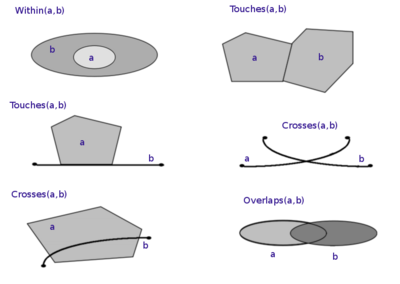


(Image by [Krauss, CC BY-SA 3.0](https://en.wikipedia.org/wiki/Spatial_relation#/media/File:TopologicSpatialRelarions2.png)

### Relationships between individual objects

Let's first create some small toy spatial objects:

A polygon <small>(note: we use `.item()` here to to extract the scalar geometry object from the GeoSeries of length 1)</small>:

In [ ]:
bagalkot = state.loc[state['district'] == 'Bagalkot', 'geometry']
dharwad = state.loc[state['district'] == 'Dharwad', 'geometry']

Adding two points

In [ ]:
bagalkot_centroid = bagalkot.geometry.union_all().centroid # I will explain union_all later
dharwad_centroid = dharwad.geometry.union_all().centroid

And a linestring

In [ ]:
from shapely.geometry import LineString
line = LineString([bagalkot_centroid, dharwad_centroid])

Let's visualize those geometry objects together:

In [ ]:
gpd.GeoSeries([bagalkot_centroid, dharwad_centroid, line]).plot(cmap='tab10')

Centroid of Dharwad, is located within Dharwad. This is a spatial relationship, and we can test this using the individual shapely geometry objects as follow:

In [ ]:
dharwad_centroid.within(dharwad.union_all())

#dharwad_centroid.within(dharwad)

And using the reverse, Dharwad contains centroid point

In [ ]:
dharwad.union_all().contains(dharwad_centroid)

On the other hand, Bagalkot centroid is not located in Dharwad

In [ ]:
bagalkot_centroid.contains(dharwad.union_all())

The straight line we draw from Dharward to Bagalkot is not fully located within Belgium, but it does intersect with it:

In [ ]:
dharwad.union_all().contains(line)

In [ ]:
line.intersects(dharwad.union_all())

<div class="alert alert-info" style="font-size:120%">

**REFERENCE**:

Overview of the different functions to check spatial relationships (*spatial predicate functions*):

* `equals`
* `contains`
* `crosses`
* `disjoint`
* `intersects`
* `overlaps`
* `touches`
* `within`
* `covers`
* `covered_by`


See https://shapely.readthedocs.io/en/stable/manual.html#predicates-and-relationships for an overview of those methods.

See https://en.wikipedia.org/wiki/DE-9IM for all details on the semantics of those operations.

</div>

## Spatial join operation

<div class="alert alert-info" style="font-size:120%">

**SPATIAL JOIN** = *transferring attributes from one layer to another based on their spatial relationship* <br>


Different parts of this operations:

* The GeoDataFrame to which we want add information
* The GeoDataFrame that contains the information we want to add
* The spatial relationship we want to use to match both datasets ('intersects', 'contains', 'within')
* The type of join: left or inner join


![](https://github.com/developmentseed/ingarss-workshop-2024/blob/main/book/docs/img/illustration-spatial-join.svg?raw=1)

</div>

# Spatial operations

Next to the spatial predicates that return boolean values, Shapely and GeoPandas also provide operations that return new geometric objects.

**Binary operations:**

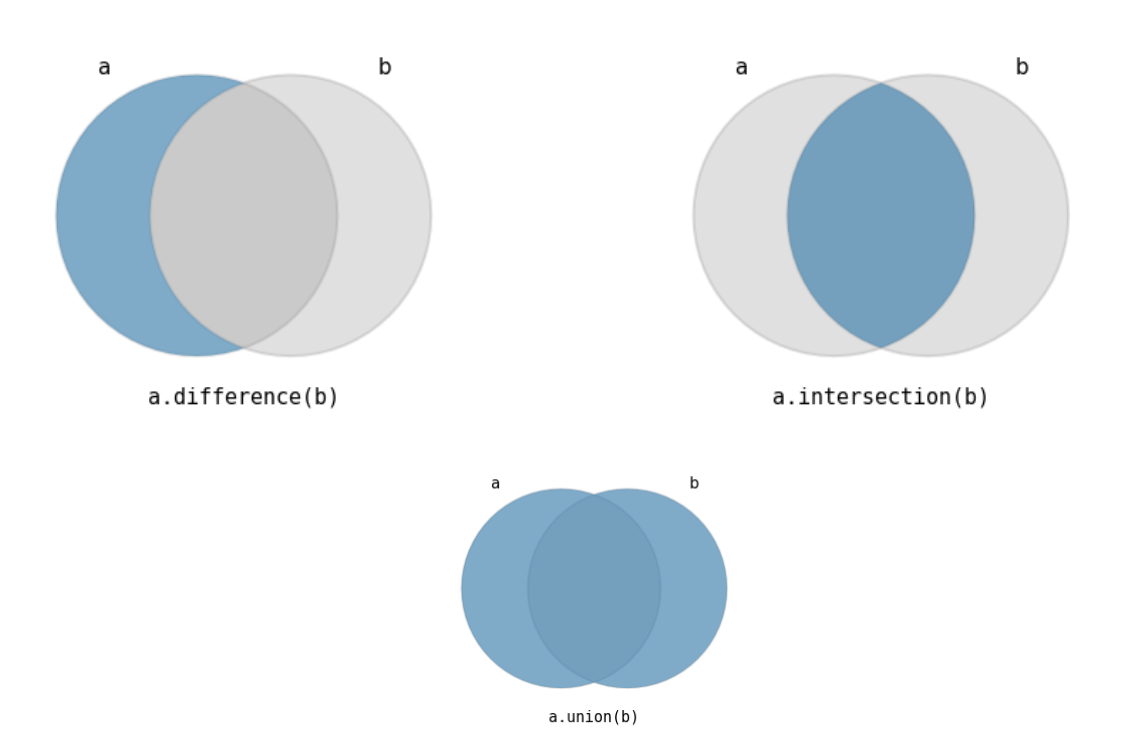

**Buffer:**

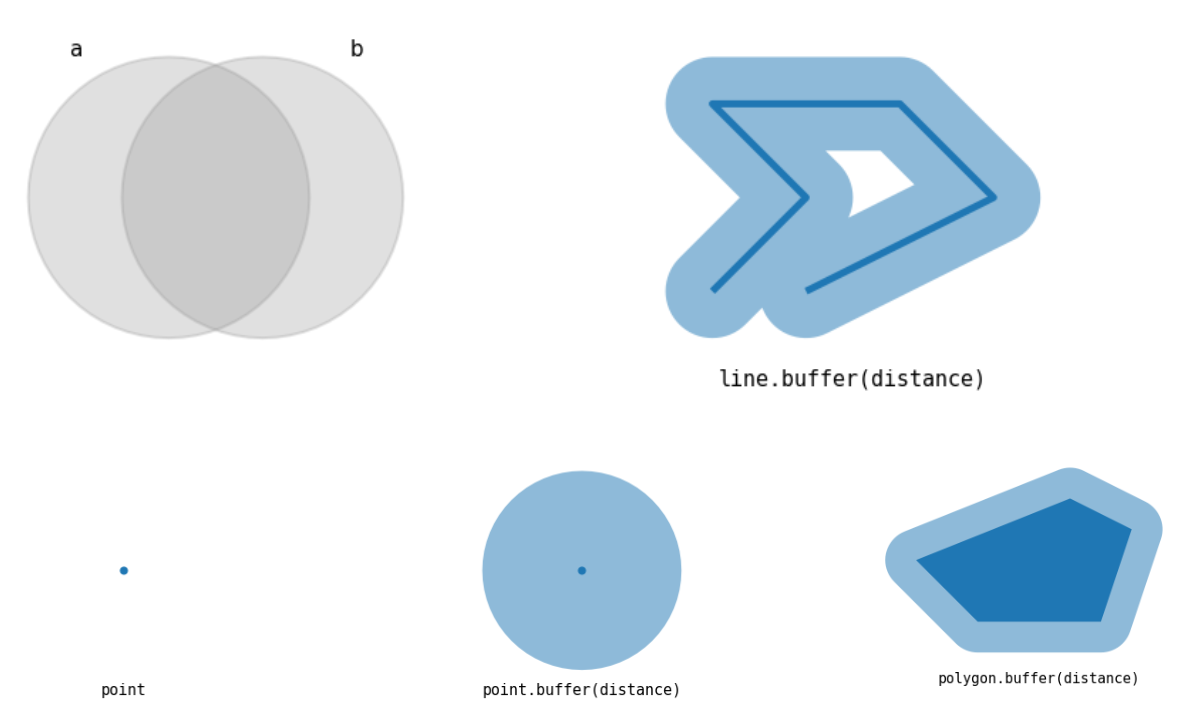

See https://shapely.readthedocs.io/en/stable/manual.html#spatial-analysis-methods for more details.

# Unary union and dissolve

Another useful method is the `unary_union` attribute, which converts the set of geometry objects in a GeoDataFrame into a single geometry object by taking the union of all those geometries.

In [ ]:
state.plot()

In [ ]:
KA = state.unary_union
KA

In [ ]:
KA

In [ ]:
districts = state.dissolve(by="district")

In [ ]:
districts #.iloc[0].geometry

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**:

GeoPandas (and Shapely for the individual objects) provide a whole lot of basic methods to analyze the geospatial data (distance, length, centroid, boundary, convex_hull, simplify, transform, ....), much more than what we can touch in this tutorial.

An overview of all methods provided by GeoPandas can be found here: https://geopandas.readthedocs.io/en/latest/docs/reference.html


</div>